In [225]:
%load_ext autoreload
%autoreload 

import sqlite3 as sql

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from shared.profile import Profiler
import shared.viz as viz
import shared.query as q
import shared.format as format

pd.set_option('display.max_colwidth', 200)
viz.set_style()

# if enabled, output graphics optimized for PowerPoint/presentation
presentation_mode = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Presto! Product Data

Presto! stands on the shoulders of giants, and on top of millions of reviews of nearly a million albums and books. This notebooks explores what data Presto! uses and where it came from.

## Data Sources Used

Presto!'s backend is built on the following data sources:

### McAuley Labs Amazon Review Dataset

https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

Used for Presto! music recommendations

#### Features
- By far the most extensive product review dataset discovered
- Actively maintained and updated
- 5 million reviews of 770 thousand albums by 230 thousand artists 
- Includes separate review vs product data

#### Limitations:
- Difficult to extract usable music data
    - CDs include audiobooks and music
    - Need to combine data from Digital Music and CDs
    - CD dataset includes misclassified products such as automobiles and laptop chargers
    - Extracting artist information requires extensive parsing from a general product info field
- No genre metadata
- No review downvote metadata
- Covers about 10% of all artists despite its large size

### Amazon Books Reviews Kaggle Dataset

https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

Used for Presto! book recommendations

#### Features
- Includes review and product data
- 3M reviews for for 212K books
- Review metadata including upvotes and downvotes
    - downvote metadata helps improve recommendations
- Genre classification
- Clean data set requiring minimal processing

#### Limitations
- Not as extensive as the McAuley equivalent (29.5M reviews for 4.4M books)

### MusicBrainz Database

https://musicbrainz.org/doc/Development/JSON_Data_Dumps

MusicBrainz boasts what looks like comprehensive up-to-date coverage of all of the world's genres, artists, albums, and songs. Though Presto! does not use MusicBrainz directly, MusicBrainz was used to help sanitize Presto!s database and to understand the landscape of worldwide music data.

#### Features
- Comprehensive coverage of all the world's music data
- Actively maintained and up-to-date

#### Limitations
- Contains product information only, not reviews

## Data Sources Considered

#### Million Song Dataset
millionsongdataset.com

A seemingly vast collection of music data that does not appear to be up-to-date. When I tested the data set on niche current artists (e.g. VNV Nation), I found gaps in coverage for current music compared to the McAuley dataset.

### Pitchfork Reviews
https://www.kaggle.com/datasets/nolanbconaway/pitchfork-data

A dataset of professionally written reviews, but nowhere near as extensive as the McAuley dataset used by Presto!

### CritiqueBrainz
https://critiquebrainz.org/

A dataset of music reviews by the creators of MusicBrainz, this dataset also falls well short of McAuley-sized coverage of artists and albums.


### Spotify API

Though once a great data source for music-related data science, Spotify has decomissioned its API resources at the time of Presto!'s creation.


#### Apple Music API
https://developer.apple.com/documentation/applemusicapi

Requires Apple-specific product IDs and does not seem to support search or user reviews, so is not usable for Presto!

#### Amazon API

There does not appear to be an Amazon API focused on obtaining large volumes of product and review data. Amazon store developer APIs are geared towards Amazon merchants managing their own stores, not toward data scientists looking for product and review data.

#### Full Score Dataset:
https://figshare.com/articles/dataset/Amazon_Reviews_Full/13232537/1?file=25483985

Like many review datasets, this large dataset does not include product data and so is not suited for a project like Presto!, which needs product and review data.

## Data Overview
Let's begin with high-level statistics about our product and review data consisting of roughly 8M reviews of 1M books and albums.

In [120]:
%load_ext autoreload
%autoreload 

import sqlite3 as sql

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from shared.profile import Profiler
import shared.viz as viz
import shared.query as q
import shared.format as format

pd.set_option('display.max_colwidth', 200)
viz.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
conn = sql.connect('data/products.sql')

### Products and Reviews by Category

Note: these queries are relatively slow. SQL indices take up substantial space, so Presto! only optimizes user-facing queries down to real-time performance.

In [3]:
p = Profiler()

review_counts = q.query(f"""
SELECT category, COUNT(*) as reviews
FROM review r
JOIN product p ON r.product_id = p.id
GROUP BY category 
""", conn).set_index('category');
p.log("Got user reviews by category")

product_counts = q.query(f"""
SELECT category, COUNT(*) AS products
FROM product 
GROUP BY category 
""", conn).set_index('category');
p.log("Got products by category")

creator_counts = q.query(f"""
SELECT category, COUNT(DISTINCT(creator)) AS creators
FROM product 
GROUP BY category 
""", conn).set_index('category');
p.log("Got artists/authors by category")

summary = pd.concat([review_counts, product_counts, creator_counts], axis = 1)

summary.map(format.describe_number)


SELECT category, COUNT(*) as reviews
FROM review r
JOIN product p ON r.product_id = p.id
GROUP BY category 
: 2 results in 4.388 seconds
4.389:	Got user reviews by category

SELECT category, COUNT(*) AS products
FROM product 
GROUP BY category 
: 2 results in 0.106 seconds
4.495:	Got products by category

SELECT category, COUNT(DISTINCT(creator)) AS creators
FROM product 
GROUP BY category 
: 2 results in 8.463 seconds
12.958:	Got artists/authors by category


,reviews,products,creators
category,,,
Books,2.6M,212.4K,127.3K
Music,4.8M,768.2K,228.4K


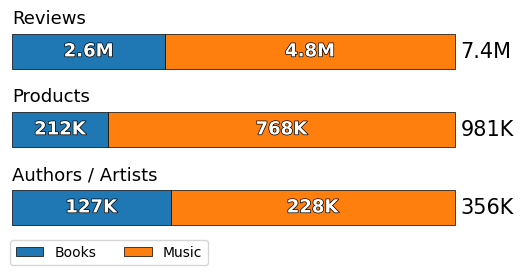

In [230]:
# plot summary stats
column_map = {
    'reviews': 'Reviews',
    'products': 'Products',
    'creators': 'Authors / Artists'
}
categories = ['Books', 'Music']
artists = []
fig, axs = plt.subplots(len(summary.columns), 1, constrained_layout = False)
for index, attribute in enumerate(summary.columns):
    ax = axs[index]
    stats = summary[attribute]
    total = 0
    for category in categories:
        value = stats[category]
        box = ax.barh(0, value, left = total, label = category, edgecolor = 'k', linewidth = 0.5)[0]
        txt = ax.annotate(
            format.describe_number(value), 
            xy = box.get_center(), verticalalignment = 'center', horizontalalignment = 'center', 
            fontsize = 13, fontweight = 'bold', color = 'w'
        )
        viz.add_outline(txt)
        total += value
        if index == 0:
            artists.append(box)
    ax.annotate(
        format.describe_number(total),
        xy = (total, 0),
        xytext = (4, 0), textcoords = 'offset points', verticalalignment = 'center',
        fontsize = 15, fontweight = 'medium'
    )
    ax.set_title(column_map[attribute], loc = 'left', fontweight = 'medium', fontsize = 13)
    ax.set_axis_off()

if presentation_mode:
    fig.set_size_inches(6,3)
else:
    fig.set_size_inches(4,3.5)
plt.subplots_adjust(hspace = 1, top = 0.8, bottom = 0.15)
fig.legend(ncols = 3, handles = artists, labels = categories, loc = 'lower left', bbox_to_anchor = [0.11,0,1,1])
if not presentation_mode:
    fig.suptitle('Presto! Product Data', horizontalalignment = 'left', fontsize = 21, x = 0.125)

plt.savefig('../images/products.png', bbox_inches = 'tight');

## Hottest Products
Find hottest books, authors, albums, and artists by using review counts

In [135]:
category = 'Books'

def most_reviewed_query(category: str, columns, limit = None) -> pd.DataFrame:
    columns = columns if isinstance(columns, str) else ','.join(columns)
    result = f"""
    SELECT p.{columns}, COUNT(*) AS reviews, p.category, p.subcategory
    FROM review r JOIN product p ON r.product_id = p.id
    WHERE category = '{category}'
    GROUP BY p.{columns} ORDER BY reviews DESC
    """
    if limit != None:
        result += f' LIMIT {limit}'
    return result

def most_reviewed(category: str, column: str, limit = None) -> pd.DataFrame:
    return q.query(most_reviewed_query(category, column, limit), conn, query_description = f'most reviewed {category} {column}s')

In [136]:
book_reviews = most_reviewed('Books', 'title')
book_reviews[:10]

most reviewed Books titles: 212397 results in 4.483 seconds


,title,reviews,category,subcategory
0,Harry Potter and The Sorcerer's Stone,6711,Books,Juvenile Fiction
1,The Hobbit There and Back Again,4331,Books,Adventure stories
2,"The Hobbitt, or there and back again; illustrated by the author.",4316,Books,Fiction
3,The Hobbit or There and Back Again,4266,Books,Juvenile Fiction
4,"The Hobbit; Or, There and Back Again",4166,Books,nan
5,The Hobbit,4118,Books,Juvenile Fiction
6,The Giver,3770,Books,Juvenile Fiction
7,Holes,3512,Books,Juvenile Fiction
8,The Catcher in the Rye,3208,Books,nan
9,The Catcher in the Rye [Audiobook] [Cd] [Unabridged] (Audio CD),3199,Books,Young Adult Fiction


Top books show that duplicate but not identical products are an ongoing issue with real-world product data. For a production-grade solution, it is worth investigating how to resolve such duplicates.

In [137]:
author_reviews = most_reviewed('Books', 'creator').rename(columns = {'creator': 'author'})
author_reviews[:10]

most reviewed Books creators: 127273 results in 2.172 seconds


,author,reviews,category,subcategory
0,nan,346121,Books,nan
1,J. R. R. Tolkien,18877,Books,Fiction
2,Charles Dickens,13905,Books,nan
3,John Steinbeck,11808,Books,Fiction
4,John Ronald Reuel Tolkien,11170,Books,"Fantasy literature, English"
5,J. K. Rowling,9852,Books,Juvenile Fiction
6,Jane Austen,9814,Books,England
7,Harper Lee,9392,Books,Study Aids
8,Stephen King,8869,Books,Fiction
9,George Orwell,8124,Books,Fiction


346K of 2.6M book reviews (roughly 1 in 8) are for books that lack an author. This deserves a follow-up investigation.

This workbook is intended to showcase our product data though. See missing_data notebook for details.

In [138]:
artist_reviews = most_reviewed('Music', 'creator').rename(columns = {'creator': 'artist'})
artist_reviews[:10]

most reviewed Music creators: 228367 results in 20.916 seconds


,artist,reviews,category,subcategory
0,Various Artists,108639,Music,
1,,41374,Music,
2,VARIOUS ARTISTS,32207,Music,
3,Various,29545,Music,
4,The Beatles,25296,Music,
5,Rated: Unrated,24376,Music,
6,Elvis Presley,16448,Music,
7,Pink Floyd,15473,Music,
8,The Rolling Stones,12656,Music,
9,Bob Dylan,12497,Music,


5 of the top 10 artists are not actually artists.

'Rated: Unrated' may be due to an issue in parsing artist data - the artist name had to be extracted from a larger body of formatted data.

The use of 'Various Artists' for compilation albums is understandable, but the data set has no clear convention for how exactly to spell this out.

In [139]:
album_reviews = most_reviewed('Music', ['title', 'creator']).rename(columns = {'creator': 'artist'})
album_reviews[:10]

most reviewed Music ['title', 'creator']s: 692618 results in 13.258 seconds


,title,artist,reviews,category,subcategory
0,25,Adele,5097,Music,
1,That's Christmas To Me,Pentatonix,3629,Music,
2,Traveller,Chris Stapleton,3211,Music,
3,Hamilton O.B.C.R. Explicit Lyrics,Lin-Manuel Miranda,3073,Music,
4,Oscd Ad Adele 21,Adele,2932,Music,
5,Partners,Barbra Streisand,2928,Music,
6,1989,Taylor Swift,2421,Music,
7,Fallen,Evanescence,2119,Music,
8,I Dreamed A Dream,Susan Boyle,2083,Music,
9,Thriller,Michael Jackson,1988,Music,


## Review Count Per Book, Album, Author, Artist

Recommender systems depend on having reasonable numbers of user reviews. To find out how many of our books, authors, albums, and artists have enough reviews to make reasonable recommendations, let's establish visual for percentage of items that have x or more reviews:

In [181]:

def items_per_review_count(values, review_counts) -> pd.DataFrame:
    """
    Converts a dataset of review counts per product to a dataset of product counts per review count.
    """
    assert(len(values) == len(review_counts))
    max_reviews = review_counts.max()
    buckets = range(0, max_reviews + 1)
    products_per_review_count = np.histogram(review_counts, bins = buckets)
    return pd.DataFrame(products_per_review_count, index = ['count', 'reviews']).T.set_index('reviews')

In [182]:
books_by_review_count = items_per_review_count(book_reviews.title, book_reviews.reviews)
authors_by_review_count = items_per_review_count(author_reviews.author, author_reviews.reviews)
albums_by_review_count = items_per_review_count(album_reviews.title, album_reviews.reviews)
artists_by_review_count = items_per_review_count(artist_reviews.artist, artist_reviews.reviews)

TypeError: plot_rates() got an unexpected keyword argument 'show_x_axis'

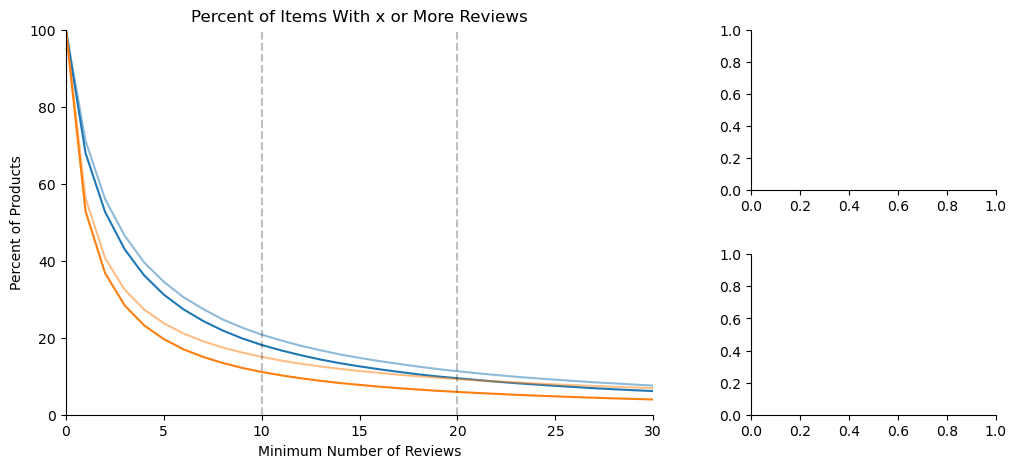

In [ ]:
plots = [
    ('Books', books_by_review_count),
    ('Authors', authors_by_review_count),
    ('Albums', albums_by_review_count),
    ('Artists', artists_by_review_count)
]

color_map = {
    'Books': 'tab:blue',
    'Authors': ('tab:blue', 0.5),
    'Albums': 'tab:orange',
    'Artists': ('tab:orange', 0.5)
}

def plot_review_cutoff(cutoff: int, ax = None):
    ax = ax or plt.gca()
    ys = [tuple[0] for tuple in plots]
    widths = [tuple[1] for tuple in plots]
    widths = [counts_by_review['count'].ccumsum().iloc[cutoff] / counts_by_review['count'].sum() for counts_by_review in widths]
    widths = [1 - x for x in widths]
    bars, _, _  = viz.plot_rates(ys, widths, color = color_map.values(), show_x_axis = False, ax = ax)
    ax.set(
        #xlabel = 'Percent of Items',
        title = f'% Items with {cutoff} Or More Reviews'
    )

def counts_to_percentages(counts: pd.Series) -> pd.Series:
    return 100 * counts.cumsum() / counts.sum()

def plot_review_count_lines(cutoffs = [10], ax = None):
    ax = ax or plt.gca()
    for title, data in plots:
        # normalize counts into percentages
        x = data.index
        y = 100 - counts_to_percentages(data['count'])
        ax.plot(x, y, label = title, color = color_map[title])
    ax.set(
        xlim = (0, 30),
        ylim = (0, 100),
        xlabel = 'Minimum Number of Reviews',
        ylabel = 'Percent of Products',
        title = f'Review Counts'
    )
    for cutoff in cutoffs:
        ax.axvline(cutoff, linestyle = '--', color = 'k', alpha = 0.25)
    ax.set_title('Percent of Items With x or More Reviews')
    ax.grid(False)


cutoffs = (10, 20)  # it takes about 10-20 ratings to make good recommendations. Feel free to tweak these values as needed.
if presentation_mode:
    fig, axs = plt.subplot_mosaic("AAB;AAC")
    fig.set_size_inches(12,5)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
else:
    fig, axs = plt.subplot_mosaic("AA;BC")
    fig.set_size_inches(8, 8)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.4)
plot_review_count_lines(cutoffs, axs['A'])
plot_review_cutoff(cutoffs[0], axs['B'])
plot_review_cutoff(cutoffs[1], axs['C'])
axs['A'].legend()

plt.savefig('../images/review_coverage.png', transparent = False)


### Conclusions - Review Counts

A large percentage of products suffers from 'review deprivation', which is a colorful term for not having enough reviews for good recommendations.

Contrary to expectations, artists and authors are not substantially less review-deprived than albums and books. This invalidates the idea of switching to artist/author recommendations if an album/book is review-deprived.

Our book dataset is of higher quality than our music dataset when it comes to review deprivation. Almost 1 in 5 books is recommendation-enabled.


### Close Connection

In [ ]:
conn.close()